<a id='Libraries'></a>
## Packages Loading

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

%matplotlib inline

In [2]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raffic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#pip install pandas
# pip install nltk
# pip install scikit-learn seaborn
# pip install matplotlab
# pip install wordcloud




<a id='EDA'></a>
## Data Preprocessing and Exploratory Data Analyasis

<a id='Data-loading'></a>
### 📥 Data Loading

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test_y = pd.read_csv("data/test_labels.csv")

### Data Analysis

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


Notice that the training data contains 159,571 observations with 8 columns and the test data contains 153,164 observations with 2 columns.

In [9]:
train.shape

(159571, 8)

In [10]:
test.shape

(153164, 2)

Below is a plot showing the comment length frequency. As noticed, most of the comments are short with only a few comments longer than 1000 words.

C:\Users\Raffic\AppData\Local\Temp\ipykernel_10956\2324281562.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comment_len, kde=False, bins=20, color="steelblue")


<Axes: xlabel='comment_text'>

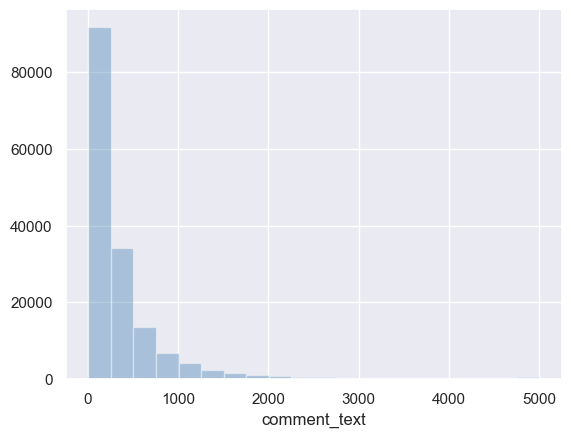

In [11]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

Further exploratory shows that label `toxic` has the most observations in the training dataset while `threat` has the least.

In [12]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

<Axes: title={'center': 'Labels Frequency'}>

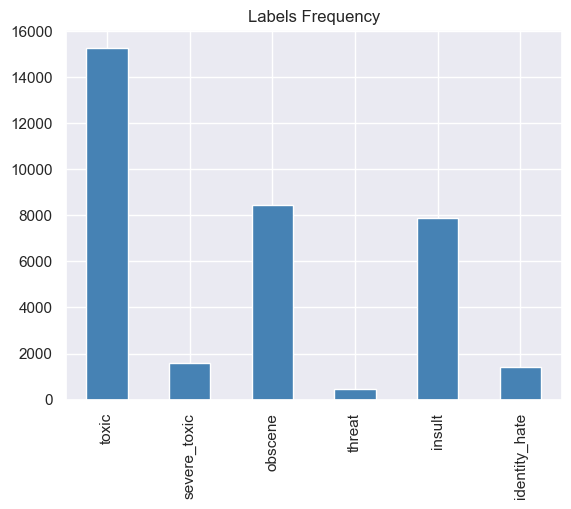

In [13]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

Below is the plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-toxic.

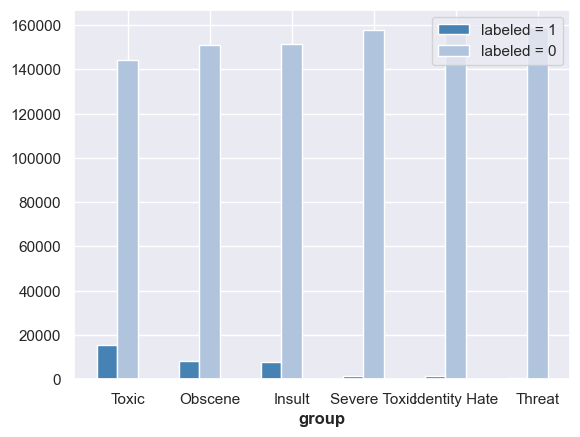

In [14]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

To get a better understanding of what the comments look like, below are examples of one clean (non-toxic) comment and one toxic (specifically, with label "toxic") comment.

In [15]:
# example of clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [16]:
# example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

It might be a great practice to see which labels are likely to appear together with a comment.

<Axes: >

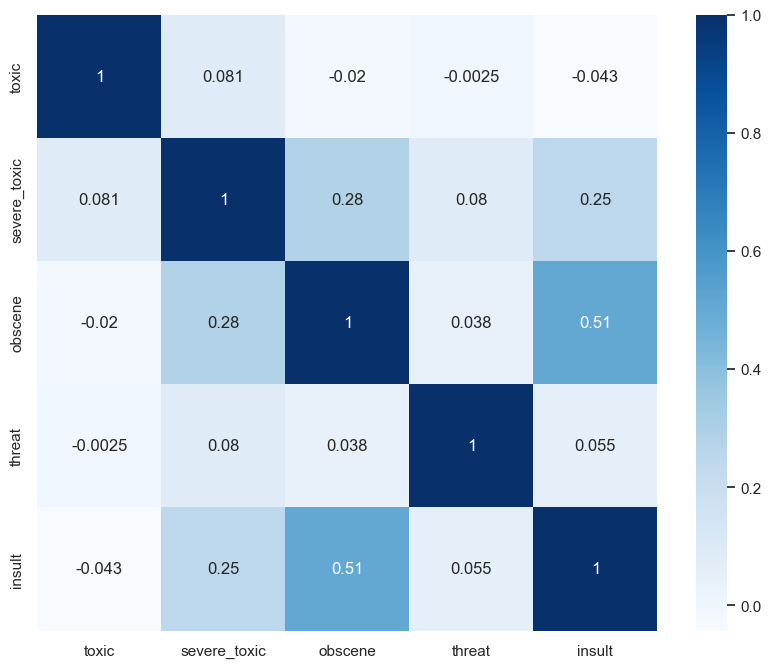

In [17]:
# Cross correlation matrix across labels
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

As seen in the cross-correlation matrix, there is a high chance of obscene comments to be insulting.

In order to get an idea of what are the words that contribute the most to different labels, we write a function to generate word clouds. The function takes in a parameter label (i.e., toxic, insult, threat, etc)

In [18]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train[train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

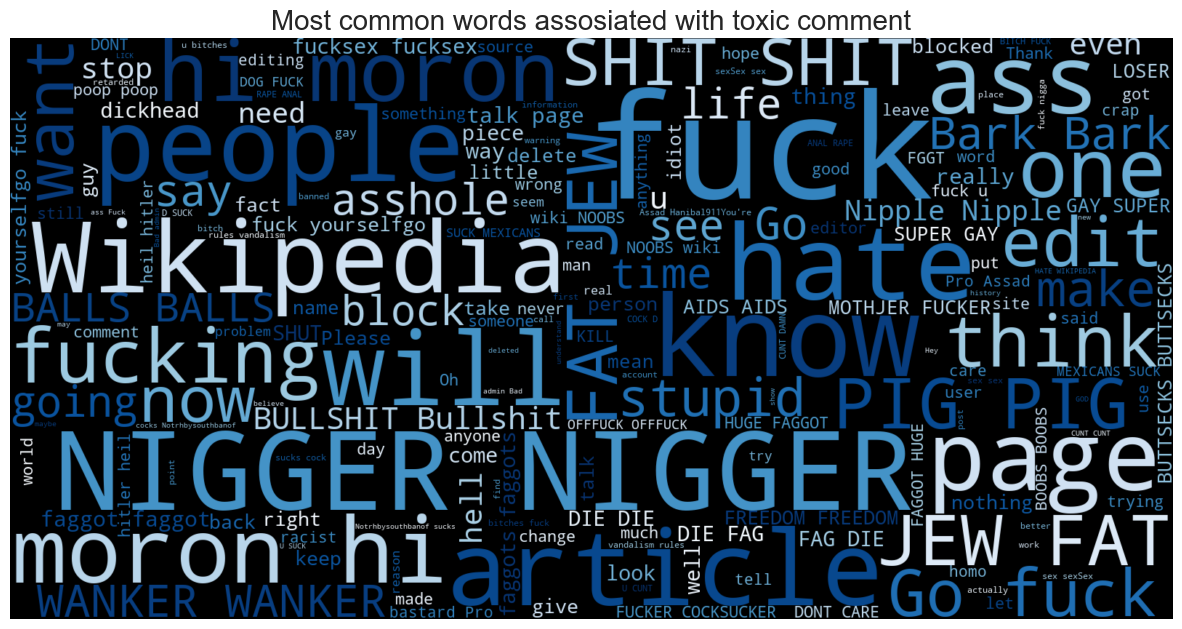

In [19]:
# interactive visual : enter the label name.
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

<a id='Feature-engineering'></a>
## Feature-engineering

In [20]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [21]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

#### TF-IDF Vectorizer

In [22]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=True, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])


c:\Users\Raffic\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


After the transformation, we can take a look at some of the features below.

In [23]:
vector.get_feature_names_out()[0:20]

array(['aaa', 'aap', 'aardvark', 'aaron', 'aba', 'abandon', 'abandoned',
       'abandoning', 'abandonment', 'abbas', 'abbey', 'abbott',
       'abbreviated', 'abbreviation', 'abc', 'abcnews', 'abd', 'abducted',
       'abduction', 'abdul'], dtype=object)

<a id='Modeling'></a>
## Modeling and Evaluation

### Baseline Model

We choose Naive Bayes as our baseline model, specifically Multinomial Naive Bayes.

Also, we want to compare between different models, especially models that perform well in text classification. Thus, we choose to compare Multinomial Naive Bayes with Logistic Regression and Linear Support Vector Machine.

We use cross Validation to compare between the baseline model and the other two models that we have chosen (LogisticRegression and LinearSVC).

In [24]:
# Creating classifiers with default parameters initially.
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [25]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [26]:
# Calculating the cross validation F1 and Recall score for our 3 baseline models.
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [27]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.482999,0.636562
1,MultinomialNB,severe_toxic,0.021938,0.042244
2,MultinomialNB,obscene,0.469167,0.622148
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,insult,0.367020,0.511394
5,MultinomialNB,identity_hate,0.007832,0.015346
6,LogisticRegression,toxic,0.612528,0.732122
7,LogisticRegression,severe_toxic,0.255185,0.351210
8,LogisticRegression,obscene,0.638658,0.748026
9,LogisticRegression,threat,0.131605,0.218787


Based on the cross validation above, we noticed that overall, the linear SVC model and Logistic Regression model perform better. As a baseline model, Multinomial Naive Bayes does not perform well, especially for the `threat` label and `identity_hate` label because these two labels have the least number of observations.

Now we want to see how these three models perform on the actual prediction - the test dataset.

### ⚔ Modeling and Evaluation

In [28]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [29]:
# Calculating the Hamming-loss F1 and Recall score for our 3 baseline models.
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [30]:
# Creating a dataframe to show summary of results.
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.935196,0.930919
1,MultinomialNB,severe_toxic,0.994436,0.992145
2,MultinomialNB,obscene,0.962987,0.957902
3,MultinomialNB,threat,0.996702,0.995056
4,MultinomialNB,insult,0.960158,0.953453
5,MultinomialNB,identity_hate,0.988887,0.983408
6,LogisticRegression,toxic,0.934321,0.936142
7,LogisticRegression,severe_toxic,0.993154,0.992851
8,LogisticRegression,obscene,0.966066,0.964416
9,LogisticRegression,threat,0.996374,0.995736


C:\Users\Raffic\AppData\Local\Temp\ipykernel_10956\2049018567.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
C:\Users\Raffic\AppData\Local\Temp\ipykernel_10956\2049018567.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Model', y='F1', data=methods,
C:\Users\Raffic\AppData\Local\Temp\ipykernel_10956\2049018567.py:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='Model', y='F1', data=methods,
C:\Users\Raffic\AppData\Local\Temp\ipykernel_10956\2049018567.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of

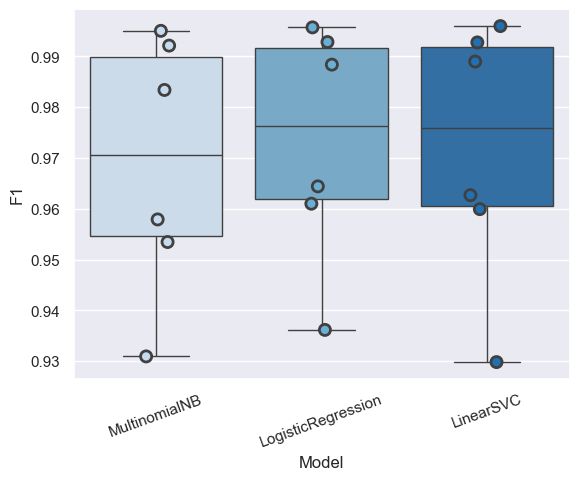

In [31]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
sns.stripplot(x='Model', y='F1', data=methods,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

### Visualzing performance till now for each classifier across each category

Plot for Multinomial Naive Bayes regression


<Axes: title={'center': 'Metrics'}, xlabel='Label'>

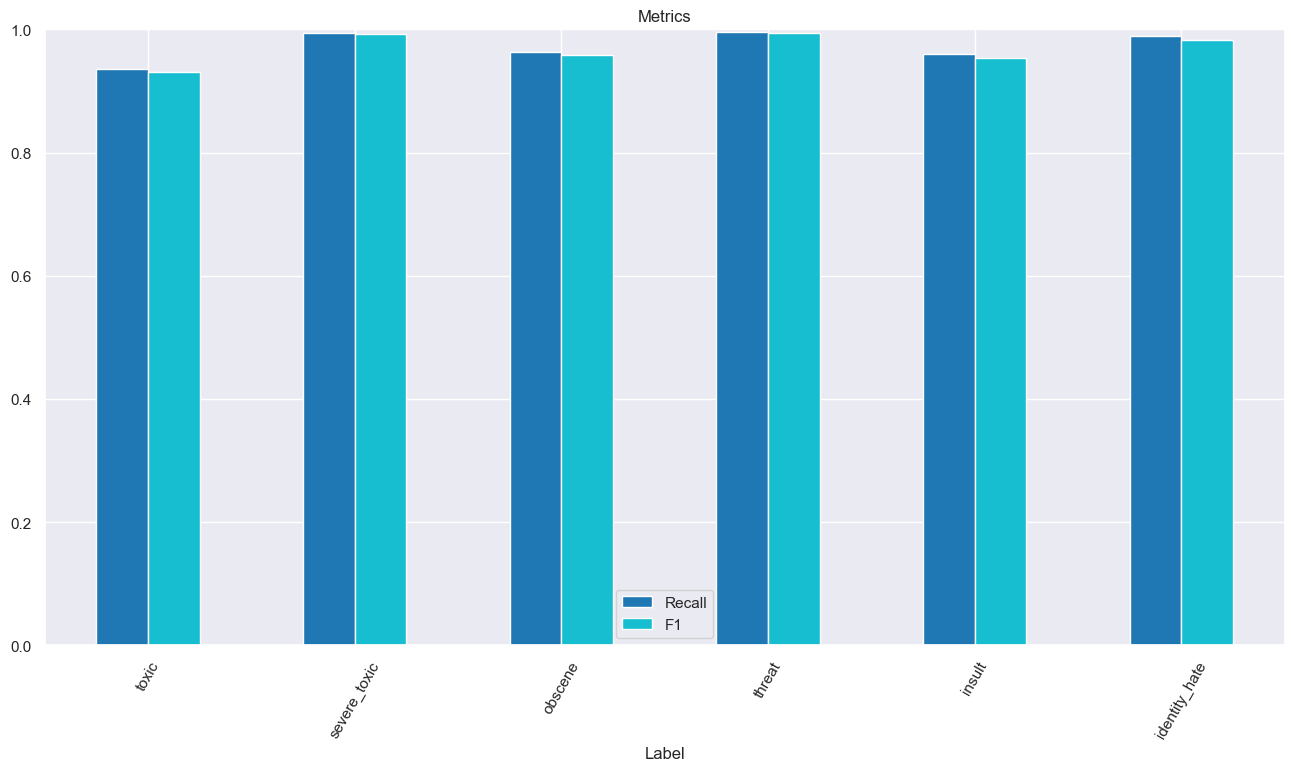

In [32]:
# Code to create bar graph of F1 and Recall across each label for Multinomial Naive Bayes
print("Plot for Multinomial Naive Bayes regression")
m2 = methods[methods.Model == 'MultinomialNB']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Logistic regression


<Axes: title={'center': 'Metrics'}, xlabel='Label'>

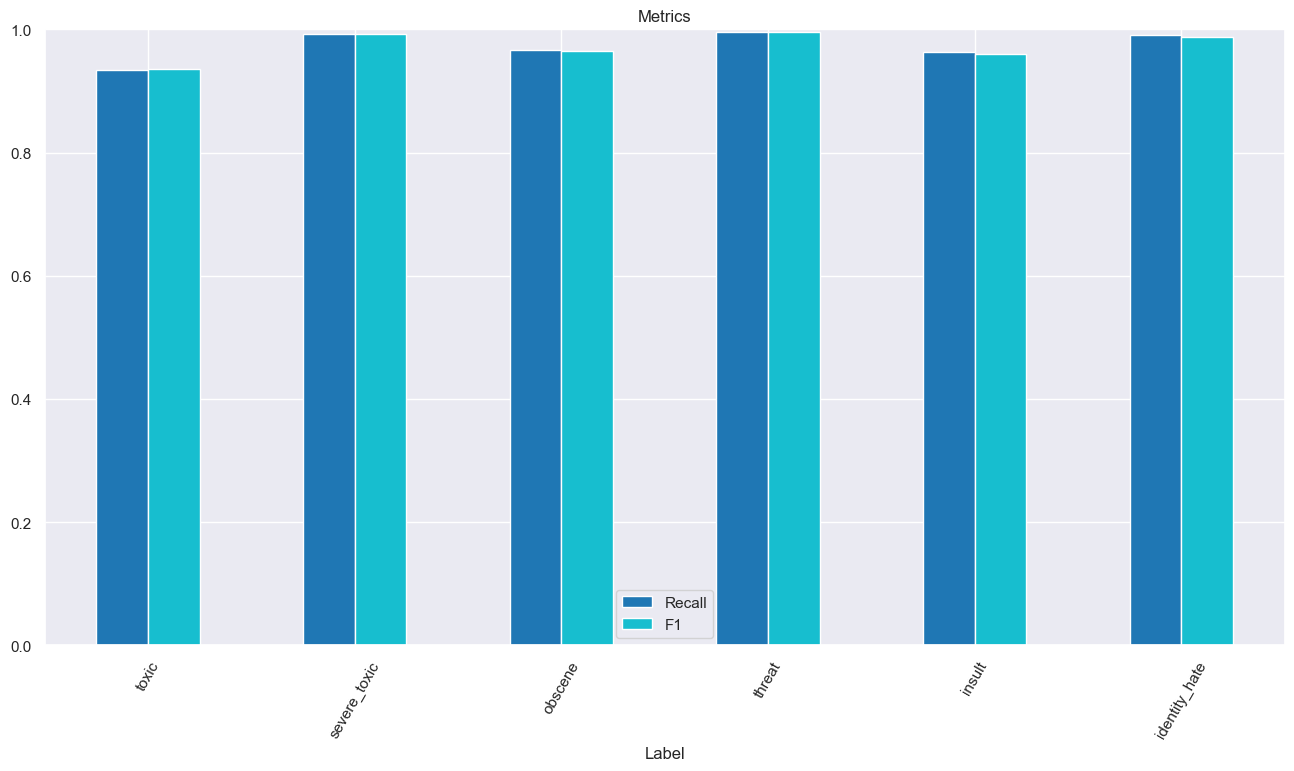

In [33]:
# Code to create bar graph of F1 and Recall across each label for Logistic regression
print("Plot for Logistic regression")
m2 = methods[methods.Model == 'LogisticRegression']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Linear SVC


<Axes: title={'center': 'Metrics'}, xlabel='Label'>

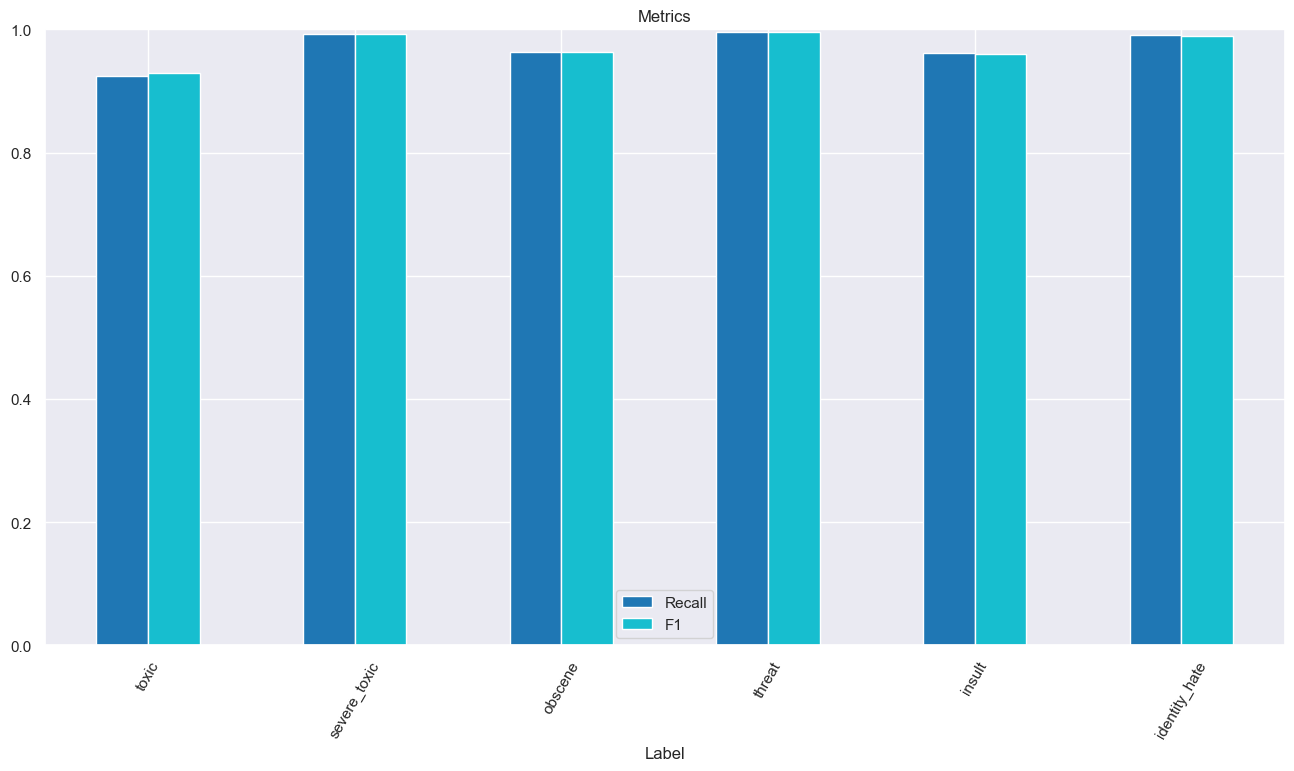

In [34]:
# Code to create bar graph of F1 and Recall across each label for Linear SVC
print("Plot for Linear SVC")
m2 = methods[methods.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

<a id='model-comparison'></a>
###  Confusion Matrix visualization

In [35]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Blues",
                fmt='.2f',
                linewidths=2,
                linecolor='steelblue',
                xticklabels=("Non-toxic", "Toxic"),
                yticklabels=("Non-toxic", "Toxic"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [36]:
def Matrix(label):
    """
    Plot Confusion matrix for each label and call function drawConfusionMatrix().
    """
    print(f"*************** {label} labelling ***************")
    labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}

    pos = labels[label]
    for i in range(pos, len(meth), 6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Below shows the confusion matrix for label `toxic`. Notice that all models predict Non-toxic labels pretty well because most of our data are non-toxic. However, Multinomial NB tends to predict more toxic comments to non-toxic while Linear SVC is doing a great job in classifying toxic comments.

*************** insult labelling ***************

****  MultinomialNB  ***


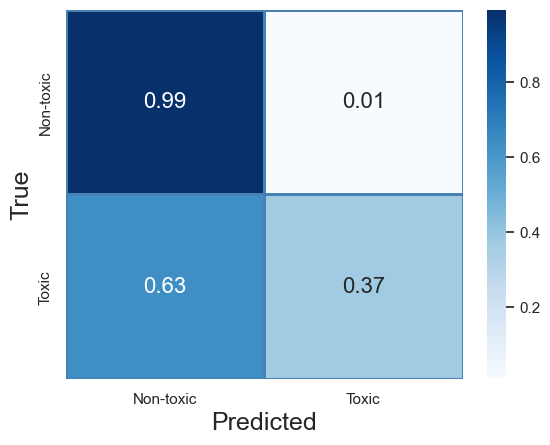


****  LogisticRegression  ***


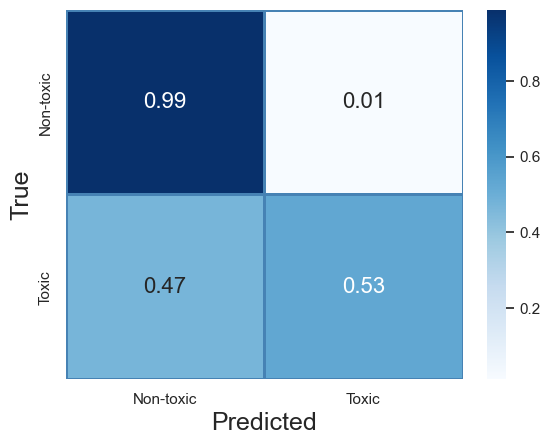


****  LinearSVC  ***


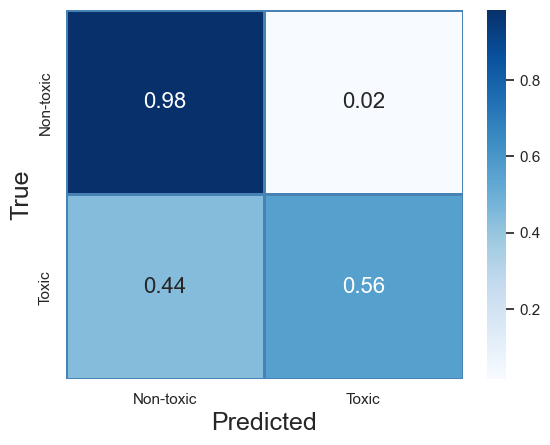

In [37]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

Based on the above comparison, we could say that for these three models with default settings, **LinearSVC performs better than anyone for 'toxic' label .**




### Aggregated Hamming Loss Score


In [38]:
# Creating a dataframe to summarize Hamming-loss
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [39]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,MultinomialNB,0.026939
1,LogisticRegression,0.026004
2,LinearSVC,0.028484


Across all models , **Logistic Regression** is doing a great job overall since it has the lowest percentage of incorrect labels.